Exploratory data analysis

In [2]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [125]:
# functions for data handling 

def load_h5py_file(filepath):
    
    with h5py.File(filepath, "r") as f:

        metadata_group = f["metadata"]
        steps_group = f["steps"]

        subdetector_meta = metadata_group["subdetector_names"][:]
        subdetector = steps_group["subdetector"][:]
        subdetector_decoded = subdetector_meta[subdetector]

        data = {
            "energy": steps_group["energy"][:],
            "event_id": steps_group["event_id"][:],
            "position": steps_group["position"][:],
            "time": steps_group["time"][:],
            "mcparticle_id": steps_group["mcparticle_id"][:],
            "subdetector": subdetector_decoded,
        }

    return data

def find_files(data_dir, particle):
    all_files = [
        os.path.join(root, file)
        for root, _, files in os.walk(data_dir)
        for file in files
        if file.endswith((".h5", ".hdf5")) and particle in file
    ]
    print(f"Found {len(all_files)} files for {particle}")
    return all_files


def convert_to_df(data):
    df = pd.DataFrame({
    "event_id": data["event_id"],
    "energy": data["energy"],
    "position_x": data["position"][:, 0],
    "position_y": data["position"][:, 1],
    "position_z": data["position"][:, 2],
    "time": data["time"],
    "mcparticle_id": data["mcparticle_id"]
    })

    return df

Event-Level Summary Statistics

In [222]:
data_dir = "data/continuous"

all_data = []

for particle in ["proton", "piM"]:
    filespaths = find_files(data_dir, particle)
    for f in filespaths:
        data = load_h5py_file(filepath=f)
        df = convert_to_df(data)
        
        df_grouped = df.groupby(['event_id']).agg(
            total_energy=('energy', 'sum'),
            n_steps=('energy', 'count'),
            n_particles=('mcparticle_id', pd.Series.nunique),
            elapsed_time=('time', lambda x: np.percentile(x, 99))
        ).reset_index()

        df_grouped["label"] = particle
        all_data.append(df_grouped)

df_all = pd.concat(all_data, ignore_index=True)

Found 5 files for proton
Found 5 files for piM


In [223]:
df_all

,event_id,total_energy,n_steps,n_particles,elapsed_time,label
0,0,0.640295,4553,968,8827.911133,proton
1,1,0.081561,676,119,9618.050781,proton
2,2,1.082019,9706,1881,7213.842285,proton
3,3,0.230641,1823,318,8599.095703,proton
4,4,0.998858,7887,1597,8012.809082,proton
...,...,...,...,...,...,...
99716,9995,0.075911,704,95,7866.433594,piM
99717,9996,1.398272,11974,1980,7121.485840,piM
99718,9997,1.197190,11731,2025,7021.957520,piM
99719,9998,0.404444,4304,668,7182.831543,piM


In [224]:
overall_stats = df_all[['total_energy', 'n_steps', 'n_particles', 'elapsed_time']].agg(['mean', 'median', 'std'])
print("Overall Event-Level Statistics:")
print(overall_stats)

stats_by_particle = df_all.groupby('label')[['total_energy', 'n_steps', 'n_particles', 'elapsed_time']].agg(['mean', 'median', 'std'])
print("\nEvent-Level Statistics by Particle Type:")
print(stats_by_particle)

Overall Event-Level Statistics:
        total_energy      n_steps  n_particles  elapsed_time
mean        0.974073  9263.094133  1580.162082   7274.276855
median      0.927696  7747.000000  1451.000000   7559.196777
std         0.605520  6626.127441  1045.571427   1795.781982

Event-Level Statistics by Particle Type:
       total_energy                          n_steps                       \
               mean    median       std         mean  median          std   
label                                                                       
piM        0.973426  0.920362  0.609491  9363.676880  7642.0  6852.171200   
proton     0.974722  0.935080  0.601511  9162.084836  7854.0  6389.560107   

        n_particles                      elapsed_time               \
               mean  median          std         mean       median   
label                                                                
piM     1603.132710  1457.0  1073.690712  7040.823730  7374.945801   
proton  1557.094

In [136]:
# load data
data_dir = "data/continuous"

dfs = []
labels = ["proton", "piM"]

for particle in labels:
    filepaths = find_files(data_dir, particle=particle)
    data = load_h5py_file(filepaths[0])
    df = convert_to_df(data)
    dfs.append(df)

Found 5 files for proton
Found 5 files for piM


In [151]:
# filter by energy 
energy_filter = 0
dfs_filtered = []

for df in dfs:
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered["energy"]>energy_filter]
    dfs_filtered.append(df_filtered)


# scale by energy
dfs_norm = []

for df in dfs_filtered:
    df_norm = df.copy()
    df_norm["energy_norm"] = df_norm["energy"]/df_norm.groupby("event_id")["energy"].transform("sum")
    dfs_norm.append(df_norm)

In [197]:
def get_bins(data, bin_count, low_pct=0, high_pct=99):

    all_vals = np.concatenate([x.ravel() for x in data])
    min_value = np.percentile(all_vals, low_pct)
    max_value = np.percentile(all_vals, high_pct)
    bins = np.linspace(min_value, max_value, bin_count+1)
    return bins


def plot_energy_distributions(dfs, label_list, meta=None, save_path=None):

    plt.figure(figsize=(6,4))
    
    energy_arrays = [df["energy_norm"].values for df in dfs]
    bins = get_bins(energy_arrays, bin_count=100)
    
    for energy_data, label in zip(energy_arrays, label_list):
        plt.hist(energy_data, bins=bins, histtype="step", alpha=0.8, label=label, density=False)

    plt.xlabel("Normalized energy (per event)")
    plt.ylabel("Number of steps")
    plt.legend()
    plt.tight_layout()
    plt.show()

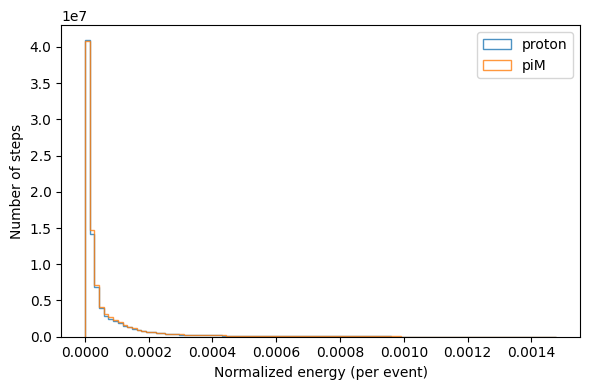

In [198]:
# plot distribution of scaled energy
plot_energy_distributions(dfs_norm, labels)

In [ ]:
def plot_single_shower(data: pd.DataFrame):

    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        data['position_x'], 
        data['position_y'], 
        data['position_z'], 
        c=data['energy'],  # color by energy
        cmap='viridis',
        s=10  # size of points
    )
    
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    
    cbar = plt.colorbar(sc)
    cbar.set_label('Energy (MeV)')
    
    plt.show()


def plot_shower_with_projections(data: pd.DataFrame):

    fig = plt.figure(figsize=(24, 4))

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    sc0= ax[0].scatter(data['position_x'], data['position_y'], c=data['energy'], cmap='viridis', s=10)
    ax[0].set_xlabel('X (mm)')
    ax[0].set_ylabel('Y (mm)')
    ax[0].set_title('XY Projection')

    sc1 = ax[1].scatter(data['position_x'], data['position_z'], c=data['energy'], cmap='viridis', s=10)
    ax[1].set_xlabel('X (mm)')
    ax[1].set_ylabel('Z (mm)')
    ax[1].set_title('XZ Projection')

    sc2 = ax[2].scatter(data['position_y'], data['position_z'], c=data['energy'], cmap='viridis', s=10)
    ax[2].set_xlabel('Y (mm)')
    ax[2].set_ylabel('Z (mm)')
    ax[2].set_title('YZ Projection')

    fig.subplots_adjust(wspace=0.02, bottom=-0.2)

    cbar = fig.colorbar(sc1, ax=ax, orientation="horizontal" , fraction=0.08)
    cbar.set_label('Energy (MeV)')
    plt.tight_layout()
    plt.show()

Found 5 files for proton


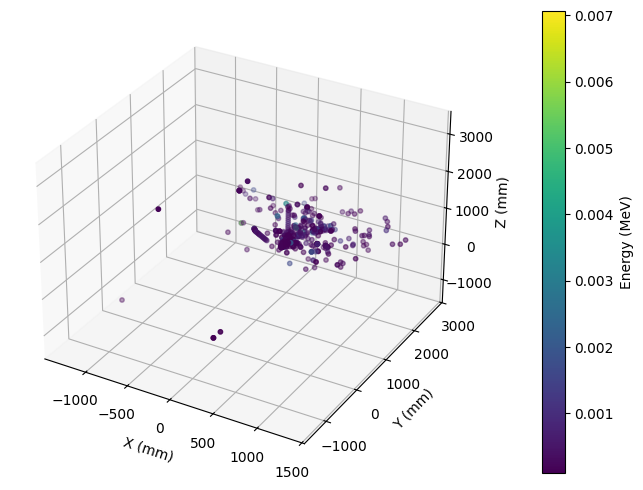

C:\Users\jakobbm\AppData\Local\Temp\ipykernel_14296\1162191271.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 2400x400 with 0 Axes>

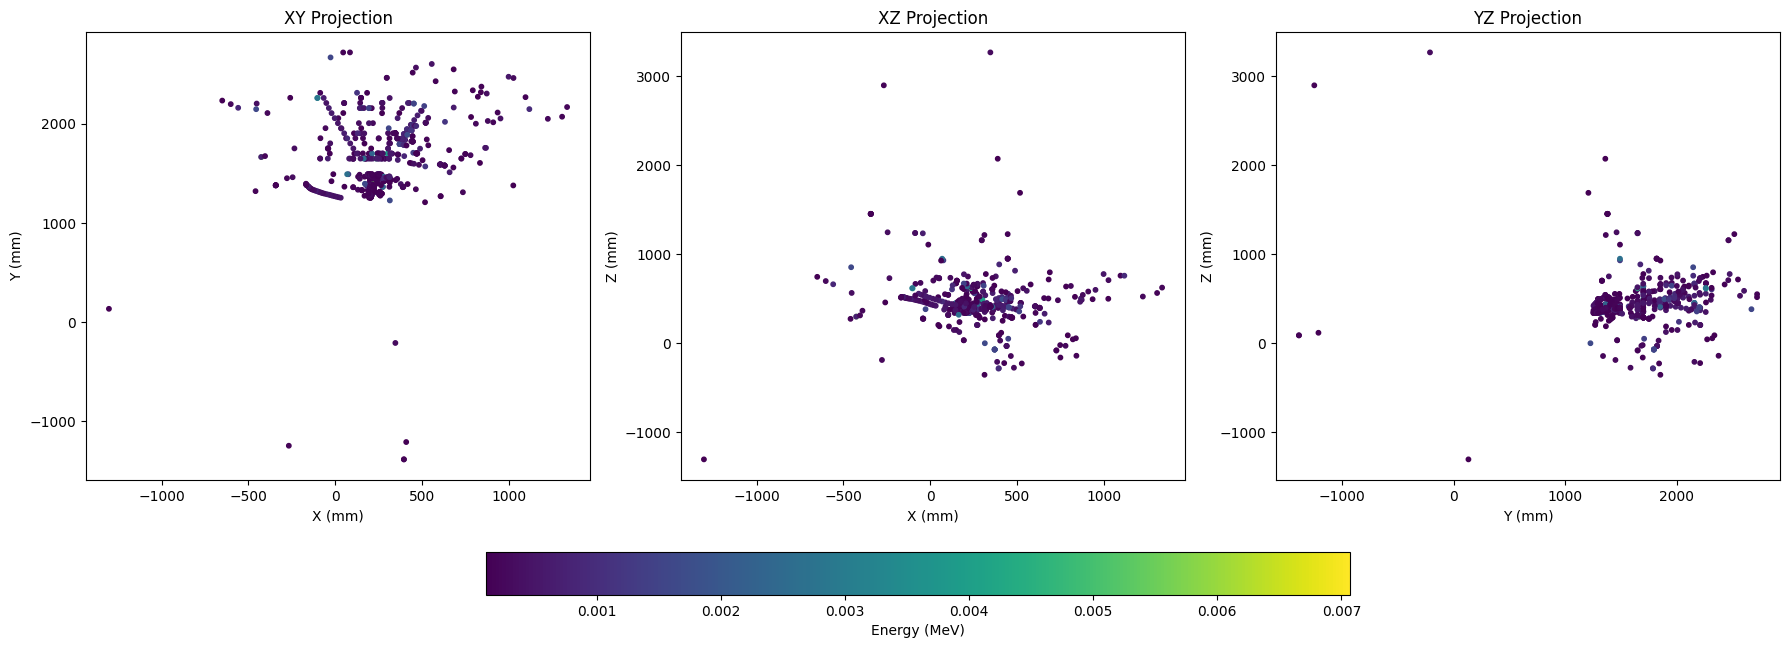

In [ ]:
# plot a single shower
data_dir = "data/continuous"
filespaths = find_files(data_dir, "proton")
data = load_h5py_file(filepath=filespaths[0])
df = convert_to_df(data)
sample = df[(df["event_id"]==7) & (df["energy"]>0.0001)]
plot_single_shower(sample)
plot_shower_with_projections(sample)

In [199]:
#chechk for missing values 

data_dir = "data/continuous"

all_data = []

for particle in ["proton", "piM"]:
    filespaths = find_files(data_dir, particle)
    for f in filespaths:
        data = load_h5py_file(filepath=f)
        df = convert_to_df(data)
        
        # Check for missing values
        missing = df.isnull().sum()
        print(f"Missing values for particle {particle} in file {f}:")
        print(missing)
        print("-" * 40)



Found 5 files for proton
Missing values for particle proton in file data/continuous\step2point_ODD_proton_0.1to100GeV_theta6to174deg_phi0to360deg_posX0Y0Z0_10000ev_file1.h5:
event_id         0
energy           0
position_x       0
position_y       0
position_z       0
time             0
mcparticle_id    0
dtype: int64
----------------------------------------
Missing values for particle proton in file data/continuous\step2point_ODD_proton_0.1to100GeV_theta6to174deg_phi0to360deg_posX0Y0Z0_10000ev_file2.h5:
event_id         0
energy           0
position_x       0
position_y       0
position_z       0
time             0
mcparticle_id    0
dtype: int64
----------------------------------------
Missing values for particle proton in file data/continuous\step2point_ODD_proton_0.1to100GeV_theta6to174deg_phi0to360deg_posX0Y0Z0_10000ev_file3.h5:
event_id         0
energy           0
position_x       0
position_y       0
position_z       0
time             0
mcparticle_id    0
dtype: int64
--------

In [ ]:
# perform correlation analysis

data_dir = "data/continuous"
all_data = []

for particle in ["proton", "piM"]:
    filespaths = find_files(data_dir, particle)
    for f in filespaths:
        data = load_h5py_file(filepath=f)
        df = convert_to_df(data)
        
        df_grouped = df.groupby(['event_id']).agg(
            total_energy=('energy', 'sum'),
            n_steps=('energy', 'count'),
            n_particles=('mcparticle_id', pd.Series.nunique),
            elapsed_time=('time', 'max')
        ).reset_index()

        df_grouped["label"] = particle
        all_data.append(df_grouped)

df_all = pd.concat(all_data, ignore_index=True)

Found 5 files for proton
Found 5 files for piM


In [209]:
len(df_all)

99721

In [208]:
len(df)

99720

In [207]:
df = df_all[df_all["elapsed_time"]<1e+12]

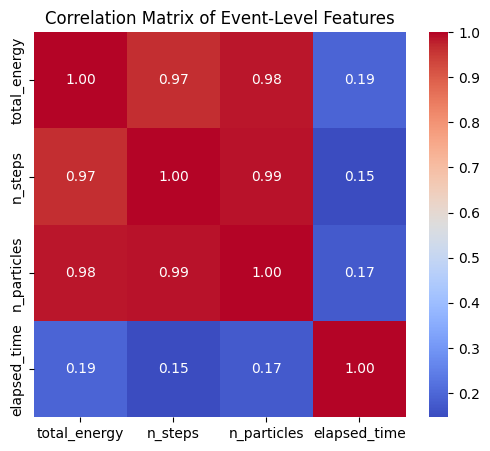

In [212]:
corr_columns = ["total_energy", "n_steps", "n_particles", "elapsed_time"]

# Compute correlation matrix
corr_matrix = df[corr_columns].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Event-Level Features")
plt.show()

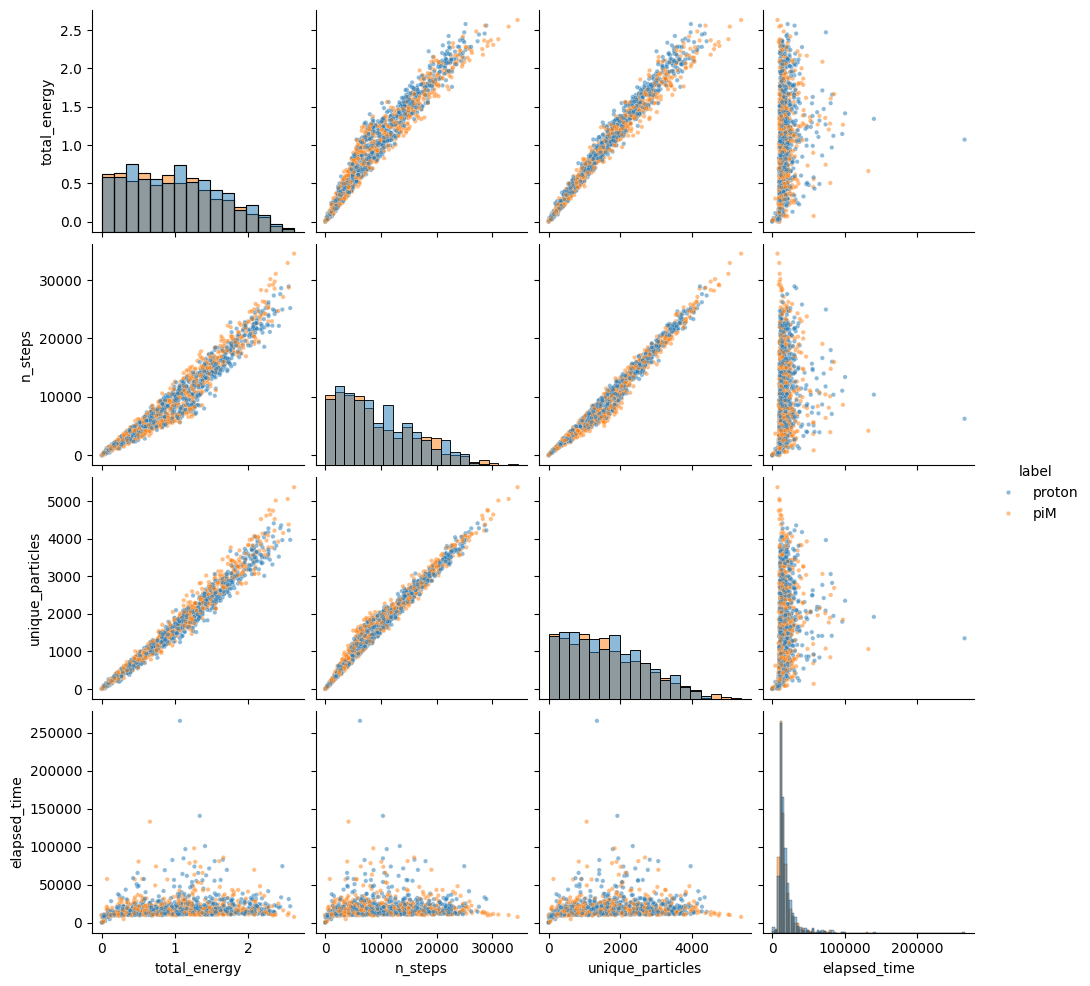

In [221]:
features_original = ["total_energy", "n_steps", "n_particles", "elapsed_time"]
features_renamed = ["total_energy", "n_steps", "unique_particles", "elapsed_time"]

# Select a random subset (e.g., 2000 events) with a fixed seed
df_subset = df_all.sample(n=1500, random_state=42)

# Rename columns for plotting
df_subset_renamed = df_subset[features_original + ["label"]].rename(
    columns=dict(zip(features_original, features_renamed))
)

# Pairplot with renamed features
sns.pairplot(
    df_subset_renamed,
    vars=features_renamed,
    hue="label",
    diag_kind="hist",
    corner=False,
    plot_kws={"alpha": 0.5, "s": 10}
)

plt.show()

In [49]:
all_dfs = [] 
for split in ["train", "test", "val"]:

    filepath = f"data/continuous/S2PT/{split}/S2PT_{split}.npz"

    data = np.load(filepath)
    df = pd.DataFrame({
        "event_id": data["event_id"],
        "total_energy": data["energy_total"],
        "n_steps": data["hits_total"],
        "energy_hcal_fraction": data["energy_hcal_frac"],
        "steps_hcal_fraction": data["hits_hcal_frac"],
        "energy_weighted_x": data["energy_weighted_x"],
        "energy_weighted_y": data["energy_weighted_y"],
        "energy_weighted_z": data["energy_weighted_z"],
        "unique_particles": data["n_particles"],
        "elapsed_time": data["elapsed_time"],
        "label": data["label"]
    })

    all_dfs.append(df)  # add to the list

# Concatenate all splits into a single DataFrame
df_all = pd.concat(all_dfs, ignore_index=True)

print("Finished loading datasets")

Finished loading datasets


In [50]:
df_all

,event_id,total_energy,n_steps,energy_hcal_fraction,steps_hcal_fraction,energy_weighted_x,energy_weighted_y,energy_weighted_z,unique_particles,elapsed_time,label
0,9763,1.392837,13344.0,0.374388,0.269709,-1423.754395,742.746887,-776.942871,2334,6345.863770,0
1,1447,0.568830,3498.0,0.980083,0.955975,340.024628,741.615845,-4554.076660,888,8692.080078,0
2,9806,1.996969,22702.0,0.111830,0.107612,-1067.501709,877.667175,-807.899963,3573,6661.695312,0
3,5602,1.044397,7045.0,0.968758,0.957559,1920.062134,-490.185608,-1439.208618,1524,8764.440430,0
4,4965,2.128215,20703.0,0.238864,0.209197,614.670837,-1328.808838,1023.069763,3307,7871.715332,0
...,...,...,...,...,...,...,...,...,...,...,...
99716,94417,0.021024,165.0,0.077108,0.315152,-728.980164,-1228.678345,699.828552,25,6747.907715,1
99717,90310,1.773597,16731.0,0.160295,0.176021,-1017.681458,974.031494,-1124.392456,2625,7315.126465,1
99718,95709,1.246182,8521.0,0.990956,0.988616,-386.943085,-887.070007,4310.994141,1833,8737.866211,1
99719,91120,2.243154,25612.0,0.177832,0.121896,823.875977,1155.027710,-427.315521,4184,4793.549316,1


In [51]:
features = ["total_energy", "n_steps", "energy_hcal_fraction", "steps_hcal_fraction", "energy_weighted_x", "energy_weighted_y", "energy_weighted_z", "unique_particles", "elapsed_time"]

# overall_stats = df[features].agg(['mean', 'median', 'std'])
# print("Overall Event-Level Statistics:")
# print(overall_stats)

stats_by_particle = df_all.groupby('label')[features].agg(['mean', 'median', 'std'])
print("\nEvent-Level Statistics by Particle Type:")
print(stats_by_particle)


Event-Level Statistics by Particle Type:
      total_energy                          n_steps                       \
              mean    median       std         mean  median          std   
label                                                                      
0         0.974722  0.935080  0.601511  9162.084836  7854.0  6389.560107   
1         0.973426  0.920362  0.609491  9363.676880  7642.0  6852.171200   

      energy_hcal_fraction                     steps_hcal_fraction  ...  \
                      mean    median       std                mean  ...   
label                                                               ...   
0                 0.427606  0.320043  0.312863            0.404409  ...   
1                 0.437984  0.308080  0.341575            0.408646  ...   

      energy_weighted_y energy_weighted_z                          \
                    std              mean     median          std   
label                                                          

In [58]:
#["total_energy", "n_steps", "energy_hcal_fraction", "steps_hcal_fraction", "energy_weighted_x", "energy_weighted_y", "energy_weighted_z", "unique_particles", "elapsed_time"]

stats_by_particle["energy_weighted_z"]

,mean,median,std
label,,,
0,11.649321,23.095617,2162.259033
1,0.311918,-10.880348,2176.242920


In [13]:
df["label"] = df["label"].map({0: "proton", 1: "piM"})

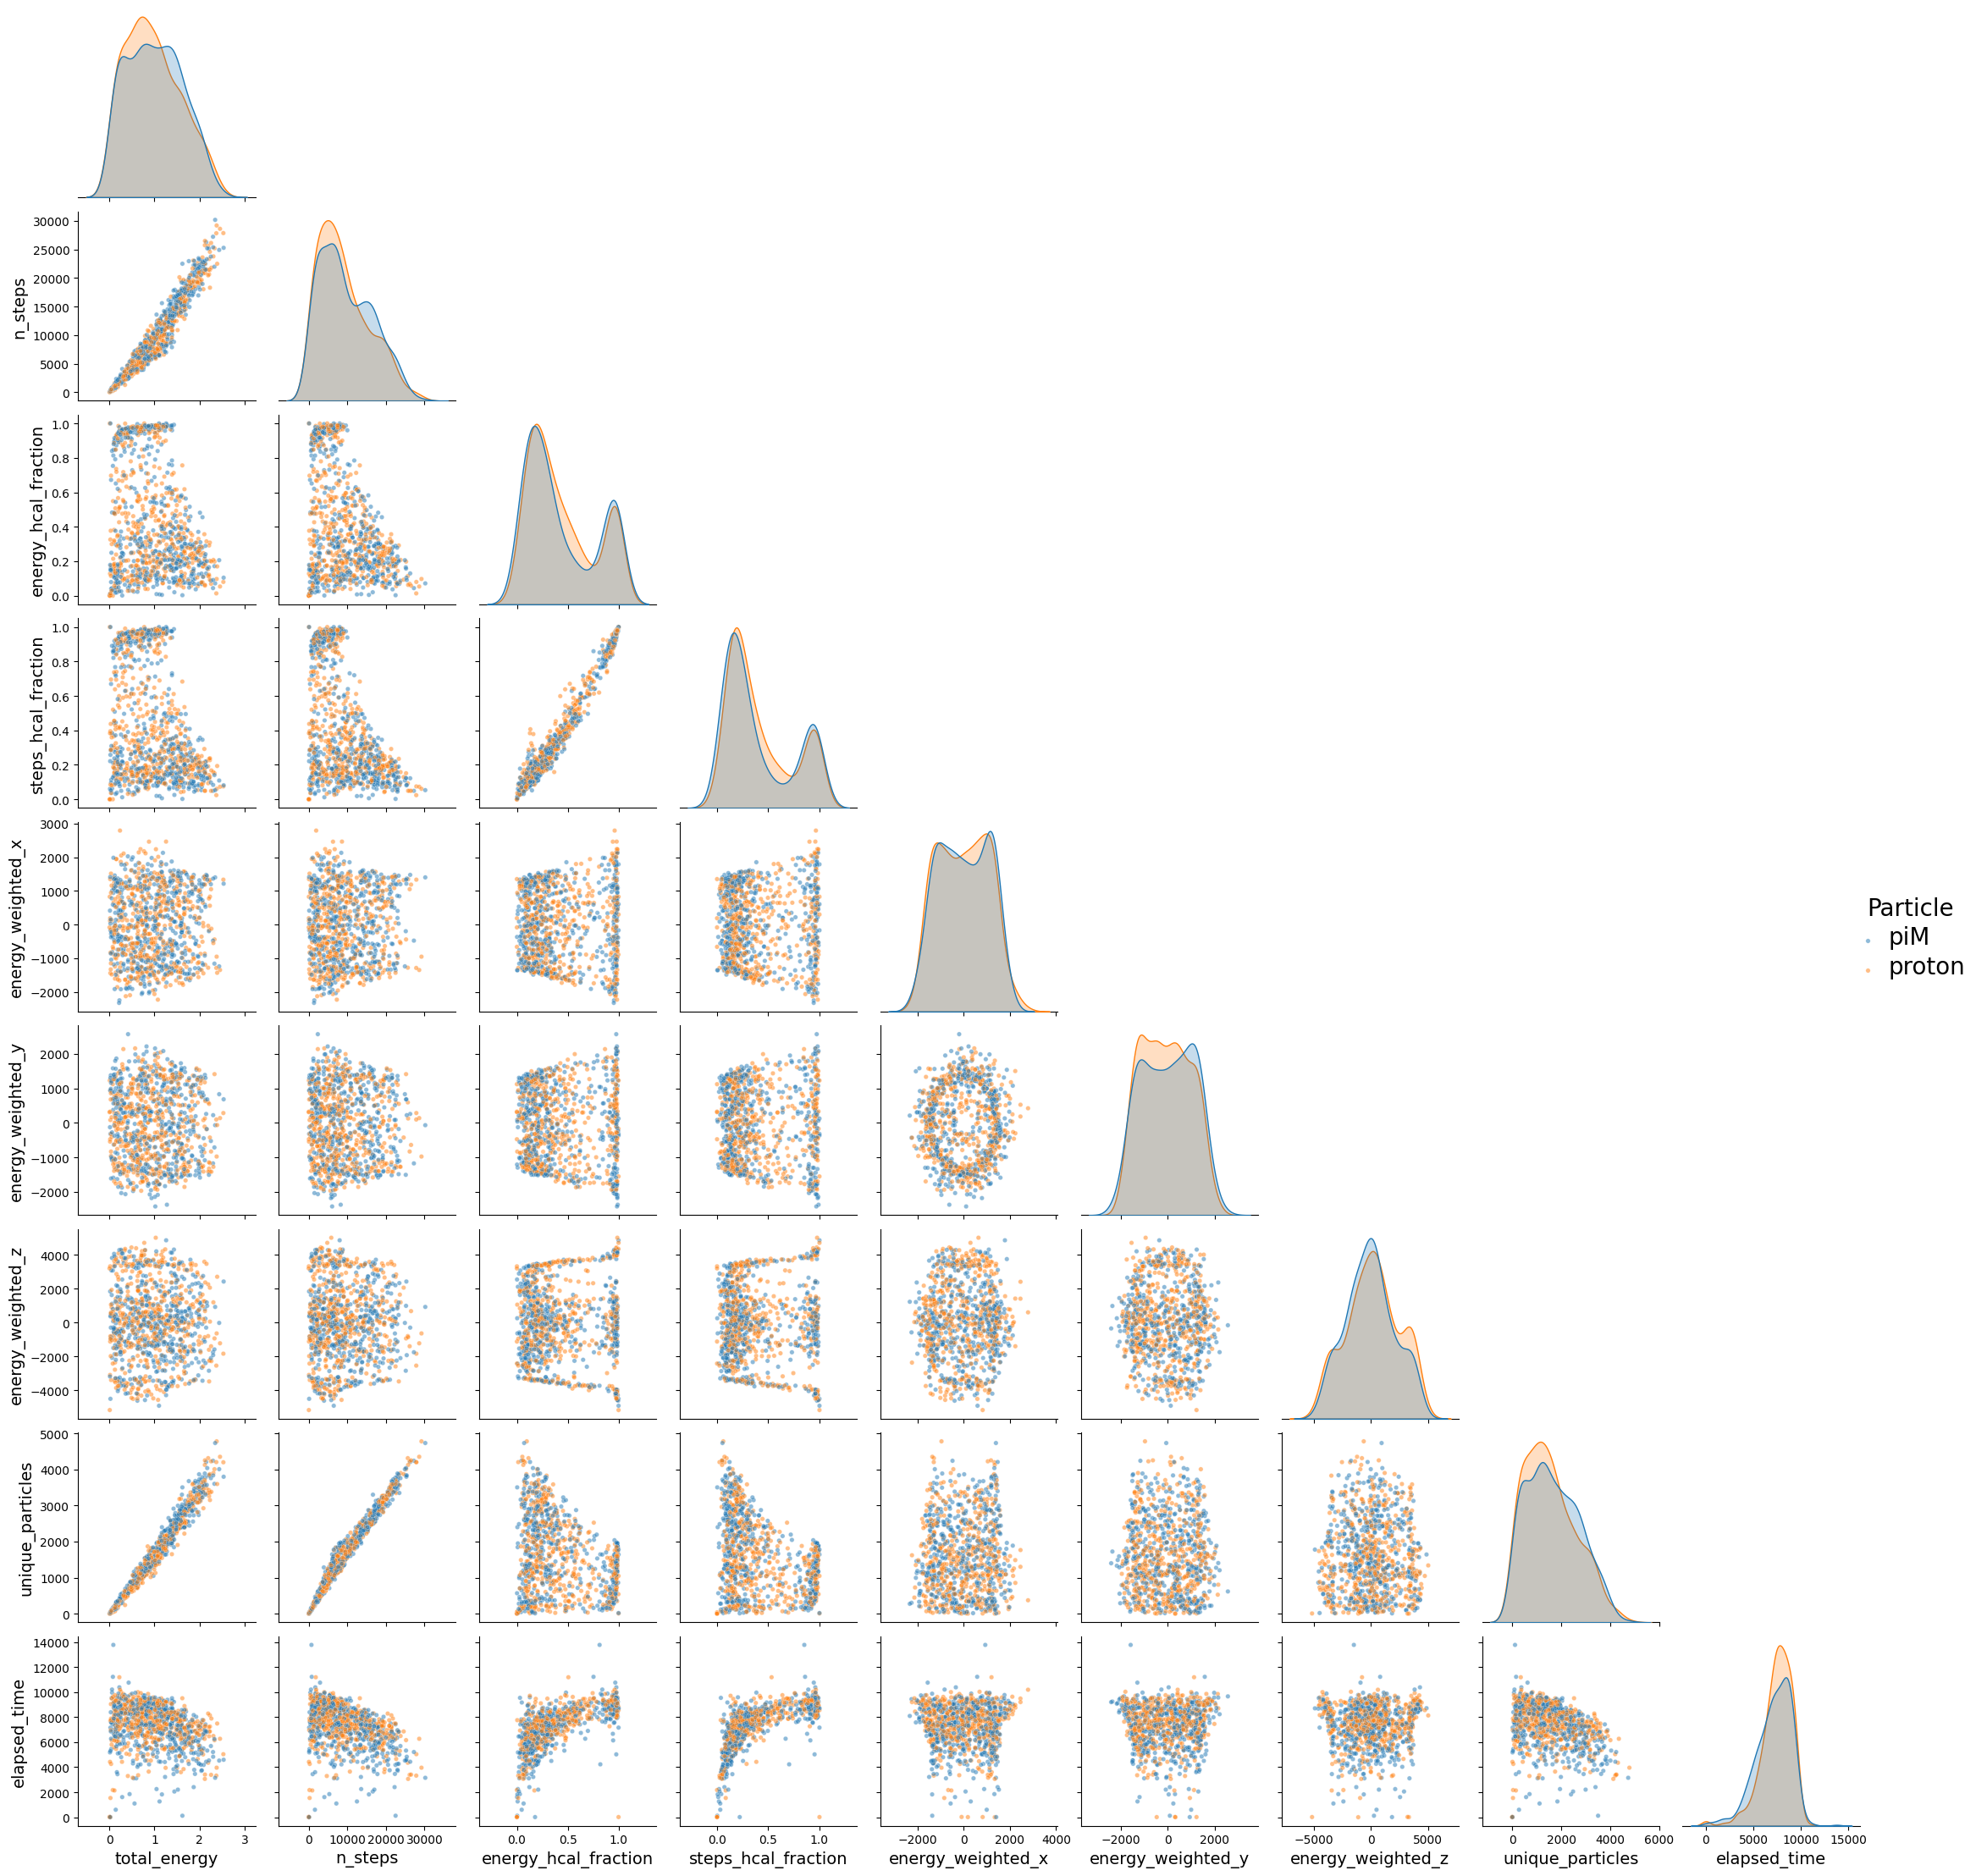

In [ ]:

# Select a random subset (e.g., 2000 events) with a fixed seed
df_subset = df.sample(n=1000, random_state=42)

# Pairplot with renamed features
g = sns.pairplot(
    df_subset,
    vars=features,
    hue="label",
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.5, "s": 15}
)

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

if g._legend is not None:
    g._legend.set_title("Particle", prop={"size": 20})  # legend title
    for t in g._legend.texts:                             # legend labels
        t.set_fontsize(20)

plt.show()



In [7]:
df

,event_id,total_energy,n_steps,energy_hcal_fraction,steps_hcal_fraction,energy_weighted_x,energy_weighted_y,energy_weighted_z,unique_particles,elapsed_time,label
0,9763,1.392837,13344.0,0.374388,0.269709,-1423.754395,742.746887,-776.942871,2334,6345.863770,0
1,1447,0.568830,3498.0,0.980083,0.955975,340.024628,741.615845,-4554.076660,888,8692.080078,0
2,9806,1.996969,22702.0,0.111830,0.107612,-1067.501709,877.667175,-807.899963,3573,6661.695312,0
3,5602,1.044397,7045.0,0.968758,0.957559,1920.062134,-490.185608,-1439.208618,1524,8764.440430,0
4,4965,2.128215,20703.0,0.238864,0.209197,614.670837,-1328.808838,1023.069763,3307,7871.715332,0
...,...,...,...,...,...,...,...,...,...,...,...
11960,12890,1.150783,12889.0,0.230566,0.205369,-434.374023,-64.087311,3493.396729,2079,7510.577637,1
11961,15075,0.397774,3530.0,0.470876,0.364306,-507.829651,-36.745232,3561.559570,649,7315.118164,1
11962,11415,0.738428,6290.0,0.774895,0.721781,1895.323608,328.146790,-732.491394,1167,8868.971680,1
11963,12923,1.327527,15237.0,0.080190,0.068649,1152.172363,-547.088745,1852.255615,2271,4717.628906,1


summary statistics what should it include? key variables mean median and stadard deviation of total shower energy and number of steps and uniqe particles elapssed time(max time) event level for distriubtion analys plot spital distribution of a single shower (2d projections) then plot historgram with with all steps with energy in bins on x axis check missing values finally correaltion anlysis on event-level total shower energy and number of steps and uniqe particles elapssed time

1. Summary Statistics

Compute basic statistics for your key variables (features) at the step level and possibly aggregated at the shower (event) level:

Energy deposited: mean, median, standard deviation, min, max.

Time: mean, median, standard deviation, min, max.

Number of steps per shower (n_steps): distribution, mean, median, variance.

3D positions: maybe compute mean/variance per axis to see shower spread.

2. Distribution Analysis

Plot histograms or KDEs for key features like energy, time, and n_steps.

Check the spatial distribution of energy deposits in the detector (3D scatter plots or 2D projections like xy, xz, yz).

Look at log-scale distributions if there are heavy tails (e.g., very high energy deposits).

3. Missing Values Analysis

Check for NaNs or missing entries in energy, time, or position.

For step-level datasets, missing data is uncommon in simulations, but it’s good to confirm.

4. Correlation Analysis

Compute correlations between numeric features: energy vs. time, energy vs. position (maybe distance from origin).

Can use scatter plots or correlation matrices to visualize.

Could also examine per-shower correlations (e.g., average energy vs. number of steps).

5. Visualizations

Some recommended visualizations for point-cloud-based showers:

Histogram of n_steps (shower length distribution).

Histogram/KDE of deposited energy.

3D scatter plot of a few showers to visualize the spatial pattern of energy deposits.

2D projections (xy, xz, yz) of the showers for multiple events.

Boxplots for energy or time to visualize variability.

Heatmaps or correlation matrices for numeric features.